알테어를 활용한 탐색적 데이터 시각화
===

(Explorative Data Visualization with Altair)
===

![altair](https://user-images.githubusercontent.com/10287629/138803189-907e3229-ba81-49c1-be97-0df36a01f013.png)

<div style="page-break-after: always;"></div>

# Cartographic Visualization

_“The making of maps is one of humanity's longest established intellectual endeavors and also one of its most complex, with scientific theory, graphical representation, geographical facts, and practical considerations blended together in an unending variety of ways.”_ &mdash; [H. J. Steward](https://books.google.com/books?id=cVy1Ms43fFYC)

Cartography &ndash; the study and practice of map-making &ndash; has a rich history spanning centuries of discovery and design. Cartographic visualization leverages mapping techniques to convey data containing spatial information, such as locations, routes, or trajectories on the surface of the Earth.

<div style="float: right; margin-left: 1em; margin-top: 1em;"><img width="300px" src="https://gist.githubusercontent.com/jheer/c90d582ef5322582cf4960ec7689f6f6/raw/8dc92382a837ccc34c076f4ce7dd864e7893324a/latlon.png" /></div>

Approximating the Earth as a sphere, we can denote positions using a spherical coordinate system of _latitude_ (angle in degrees north or south of the _equator_) and _longitude_ (angle in degrees specifying east-west position). In this system, a _parallel_ is a circle of constant latitude and a _meridian_ is a circle of constant longitude. The [_prime meridian_](https://en.wikipedia.org/wiki/Prime_meridian) lies at 0° longitude and by convention is defined to pass through the Royal Observatory in Greenwich, England.

To "flatten" a three-dimensional sphere on to a two-dimensional plane, we must apply a [projection](https://en.wikipedia.org/wiki/Map_projection) that maps (`longitude`, `latitude`) pairs to (`x`, `y`) coordinates. Similar to [scales](https://github.com/uwdata/visualization-curriculum/blob/master/altair_scales_axes_legends.ipynb), projections map from a data domain (spatial position) to a visual range (pixel position). However, the scale mappings we've seen thus far accept a one-dimensional domain, whereas map projections are inherently two-dimensional.

In this notebook, we will introduce the basics of creating maps and visualizing spatial data with Altair, including:

- Data formats for representing geographic features,
- Geo-visualization techniques such as point, symbol, and choropleth maps, and
- A review of common cartographic projections.

_This notebook is part of the [data visualization curriculum](https://github.com/uwdata/visualization-curriculum)._

In [1]:
import pandas as pd
import altair as alt
from vega_datasets import data

## Geographic Data: GeoJSON and TopoJSON

Up to this point, we have worked with JSON and CSV formatted datasets that correspond to data tables made up of rows (records) and columns (fields). In order to represent geographic regions (countries, states, _etc._) and trajectories (flight paths, subway lines, _etc._), we need to expand our repertoire with additional formats designed to support rich geometries.

[GeoJSON](https://en.wikipedia.org/wiki/GeoJSON) models geographic features within a specialized JSON format. A GeoJSON `feature` can include geometric data &ndash; such as `longitude`, `latitude` coordinates that make up a country boundary &ndash; as well as additional data attributes.

Here is a GeoJSON `feature` object for the boundary of the U.S. state of Colorado:

~~~ json
{
  "type": "Feature",
  "id": 8,
  "properties": {"name": "Colorado"},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [[-106.32056285448942,40.998675790862656],[-106.19134826714341,40.99813863734313],[-105.27607827344248,40.99813863734313],[-104.9422739227986,40.99813863734313],[-104.05212898774828,41.00136155846029],[-103.57475287338661,41.00189871197981],[-103.38093099236758,41.00189871197981],[-102.65589358559272,41.00189871197981],[-102.62000064466328,41.00189871197981],[-102.052892177978,41.00189871197981],[-102.052892177978,40.74889940428302],[-102.052892177978,40.69733266640851],[-102.052892177978,40.44003613055551],[-102.052892177978,40.3492571857556],[-102.052892177978,40.00333031918079],[-102.04930288388505,39.57414465707943],[-102.04930288388505,39.56823596836465],[-102.0457135897921,39.1331416175485],[-102.0457135897921,39.0466599009048],[-102.0457135897921,38.69751011321283],[-102.0457135897921,38.61478847120581],[-102.0457135897921,38.268861604631],[-102.0457135897921,38.262415762396685],[-102.04212429569915,37.738153927339205],[-102.04212429569915,37.64415206142214],[-102.04212429569915,37.38900413964724],[-102.04212429569915,36.99365914927603],[-103.00046581851544,37.00010499151034],[-103.08660887674611,37.00010499151034],[-104.00905745863294,36.99580776335414],[-105.15404227428235,36.995270609834606],[-105.2222388620483,36.995270609834606],[-105.7175614468747,36.99580776335414],[-106.00829426840322,36.995270609834606],[-106.47490250048605,36.99365914927603],[-107.4224761410235,37.00010499151034],[-107.48349414060355,37.00010499151034],[-108.38081766383978,36.99903068447129],[-109.04483707103458,36.99903068447129],[-109.04483707103458,37.484617466122884],[-109.04124777694163,37.88049961001363],[-109.04124777694163,38.15283644441336],[-109.05919424740635,38.49983761802722],[-109.05201565922046,39.36680339854235],[-109.05201565922046,39.49786885730673],[-109.05201565922046,39.66062637372313],[-109.05201565922046,40.22248895514744],[-109.05201565922046,40.653823231326896],[-109.05201565922046,41.000287251421234],[-107.91779872584989,41.00189871197981],[-107.3183866123281,41.00297301901887],[-106.85895696843116,41.00189871197981],[-106.32056285448942,40.998675790862656]]
    ]
  }
}
~~~

The `feature` includes a `properties` object, which can include any number of data fields, plus a `geometry` object, which in this case contains a single polygon that consists of `[longitude, latitude]` coordinates for the state boundary. The coordinates continue off to the right for a while should you care to scroll...

To learn more about the nitty-gritty details of GeoJSON, see the [official GeoJSON specification](http://geojson.org/) or read [Tom MacWright's helpful primer](https://macwright.org/2015/03/23/geojson-second-bite).

One drawback of GeoJSON as a storage format is that it can be redundant, resulting in larger file sizes. Consider: Colorado shares boundaries with six other states (seven if you include the corner touching Arizona). Instead of using separate, overlapping coordinate lists for each of those states, a more compact approach is to encode shared borders only once, representing the _topology_ of geographic regions. Fortunately, this is precisely what the [TopoJSON](https://github.com/topojson/topojson/blob/master/README.md) format does!

Let's load a TopoJSON file of world countries (at 110 meter resolution):

In [2]:
world = data.world_110m.url
world

'https://vega.github.io/vega-datasets/data/world-110m.json'

In [3]:
world_topo = data.world_110m()

In [4]:
world_topo.keys()

dict_keys(['type', 'transform', 'objects', 'arcs'])

In [5]:
world_topo['type']

'Topology'

In [6]:
world_topo['objects'].keys()

dict_keys(['land', 'countries'])

_Inspect the `world_topo` TopoJSON dictionary object above to see its contents._

In the data above, the `objects` property indicates the named elements we can extract from the data: geometries for all `countries`, or a single polygon representing all `land` on Earth. Either of these can be unpacked to GeoJSON data we can then visualize.

As TopoJSON is a specialized format, we need to instruct Altair to parse the TopoJSON format, indicating which named faeture object we wish to extract from the topology. The following code indicates that we want to extract GeoJSON features from the `world` dataset for the `countries` object:

~~~ js
alt.topo_feature(world, 'countries')
~~~

This `alt.topo_feature` method call expands to the following Vega-Lite JSON:

~~~ json
{
  "values": world,
  "format": {"type": "topojson", "feature": "countries"}
}
~~~

Now that we can load geographic data, we're ready to start making maps!

## Geoshape Marks

To visualize geographic data, Altair provides the `geoshape` mark type. To create a basic map, we can create a `geoshape` mark and pass it our TopoJSON data, which is then unpacked into GeoJSON features, one for each country of the world:

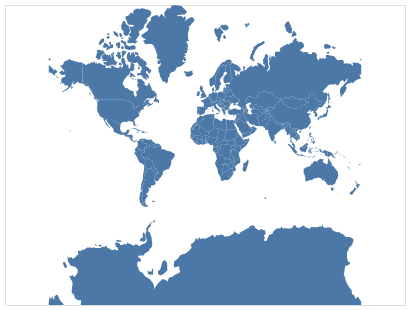

In [7]:
alt.Chart(alt.topo_feature(world, 'countries')).mark_geoshape()

In the example above, Altair applies a default blue color and uses a default map projection (`mercator`). We can customize the colors and boundary stroke widths using standard mark properties. Using the `project` method we can also add our own map projection:

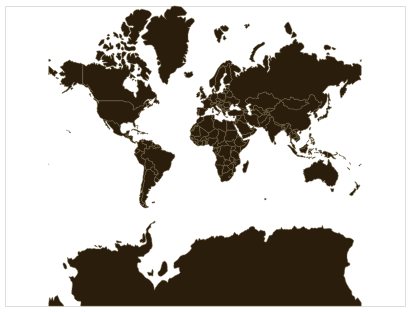

In [8]:
alt.Chart(alt.topo_feature(world, 'countries')).mark_geoshape(
    fill='#2a1d0c', stroke='#706545', strokeWidth=0.5
).project(
    type='mercator'
)

By default Altair automatically adjusts the projection so that all the data fits within the width and height of the chart. We can also specify projection parameters, such as `scale` (zoom level) and `translate` (panning), to customize the projection settings. Here we adjust the `scale` and `translate` parameters to focus on Europe:

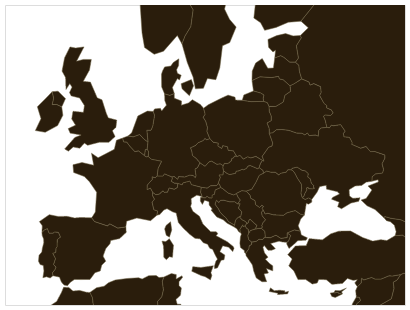

In [9]:
alt.Chart(alt.topo_feature(world, 'countries')).mark_geoshape(
    fill='#2a1d0c', stroke='#706545', strokeWidth=0.5
).project(
    type='mercator', scale=400, translate=[100, 550]
)

_Note how the 110m resolution of the data becomes apparent at this scale. To see more detailed coast lines and boundaries, we need an input file with more fine-grained geometries. Adjust the `scale` and `translate` parameters to focus the map on other regions!_

So far our map shows countries only. Using the `layer` operator, we can combine multiple map elements. Altair includes _data generators_ we can use to create data for additional map layers:

- The sphere generator (`{'sphere': True}`) provides a GeoJSON representation of the full sphere of the Earth. We can create an additional `geoshape` mark that fills in the shape of the Earth as a background layer.
- The graticule generator (`{'graticule': ...}`) creates a GeoJSON feature representing a _graticule_: a grid formed by lines of latitude and longitude. The default graticule has meridians and parallels every 10° between ±80° latitude. For the polar regions, there are meridians every 90°. These settings can be customized using the `stepMinor` and `stepMajor` properties.

Let's layer sphere, graticule, and country marks into a reusable map specification:

In [10]:
map = alt.layer(
    # use the sphere of the Earth as the base layer
    alt.Chart({'sphere': True}).mark_geoshape(
        fill='#e6f3ff'
    ),
    # add a graticule for geographic reference lines
    alt.Chart({'graticule': True}).mark_geoshape(
        stroke='#ffffff', strokeWidth=1
    ),
    # and then the countries of the world
    alt.Chart(alt.topo_feature(world, 'countries')).mark_geoshape(
        fill='#2a1d0c', stroke='#706545', strokeWidth=0.5
    )
).properties(
    width=600,
    height=400
)

We can extend the map with a desired projection and draw the result. Here we apply a [Natural Earth projection](https://en.wikipedia.org/wiki/Natural_Earth_projection). The _sphere_ layer provides the light blue background; the _graticule_ layer provides the white geographic reference lines.

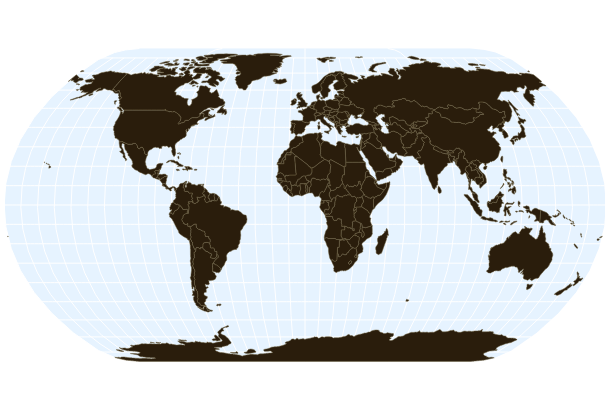

In [11]:
map.project(
    type='naturalEarth1', scale=110, translate=[300, 200]
).configure_view(stroke=None)

## Point Maps

In addition to the _geometric_ data provided by GeoJSON or TopoJSON files, many tabular datasets include geographic information in the form of fields for `longitude` and `latitude` coordinates, or references to geographic regions such as country names, state names, postal codes, _etc._, which can be mapped to coordinates using a [geocoding service](https://en.wikipedia.org/wiki/Geocoding). In some cases, location data is rich enough that we can see meaningful patterns by projecting the data points alone &mdash; no base map required!

Let's look at a dataset of 5-digit zip codes in the United States, including `longitude`, `latitude` coordinates for each post office in addition to a `zip_code` field.

In [12]:
zipcodes = data.zipcodes.url
zipcodes

'https://vega.github.io/vega-datasets/data/zipcodes.csv'

We can visualize each post office location using a small (1-pixel) `square` mark. However, to set the positions we do _not_ use `x` and `y` channels. _Why is that?_

While cartographic projections map (`longitude`, `latitude`) coordinates to (`x`, `y`) coordinates, they can do so in arbitrary ways. There is no guarantee, for example, that `longitude` → `x` and `latitude` → `y`! Instead, Altair includes special `longitude` and `latitude` encoding channels to handle geographic coordinates. These channels indicate which data fields should be mapped to `longitude` and `latitude` coordinates, and then applies a projection to map those coordinates to (`x`, `y`) positions.

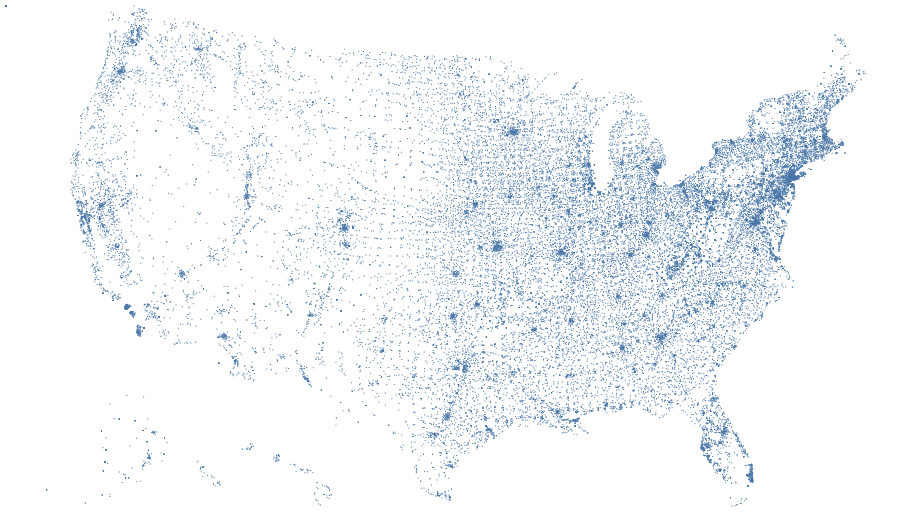

In [13]:
alt.Chart(zipcodes).mark_square(
    size=1, opacity=1
).encode(
    longitude='longitude:Q', # apply the field named 'longitude' to the longitude channel
    latitude='latitude:Q'    # apply the field named 'latitude' to the latitude channel
).project(
    type='albersUsa'
).properties(
    width=900,
    height=500
).configure_view(
    stroke=None
)

_Plotting zip codes only, we can see the outline of the United States and discern meaningful patterns in the density of post offices, without a base map or additional reference elements!_

We use the `albersUsa` projection, which takes some liberties with the actual geometry of the Earth, with scaled versions of Alaska and Hawaii in the bottom-left corner. As we did not specify projection `scale` or `translate` parameters, Altair sets them automatically to fit the visualized data. 

We can now go on to ask more questions of our dataset. For example, is there any rhyme or reason to the allocation of zip codes? To assess this question we can add a color encoding based on the first digit of the zip code. We first add a `calculate` transform to extract the first digit, and encode the result using the color channel:

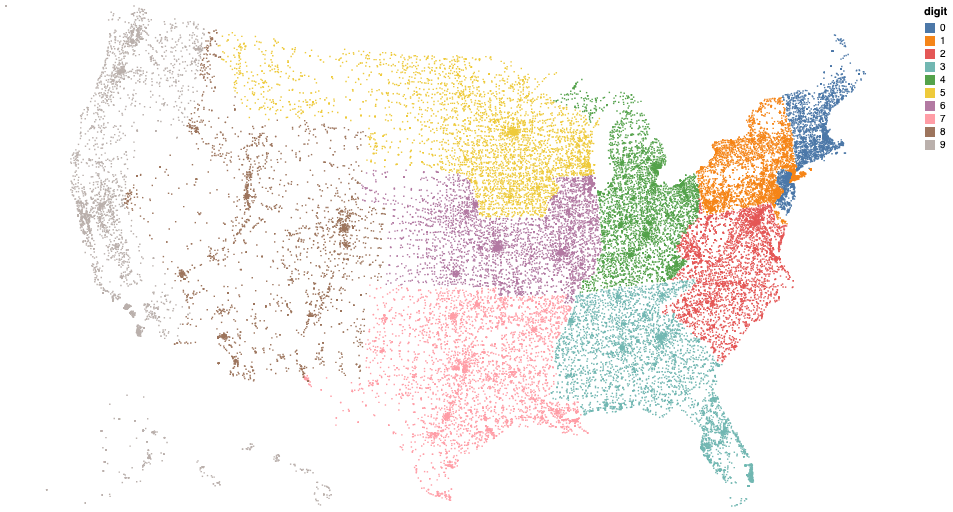

In [14]:
alt.Chart(zipcodes).transform_calculate(
    digit='datum.zip_code[0]'
).mark_square(
    size=2, opacity=1
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='digit:N'
).project(
    type='albersUsa'
).properties(
    width=900,
    height=500
).configure_view(
    stroke=None
)

_To zoom in on a specific digit, add a filter transform to limit the data shown! Try adding an [interactive selection](https://github.com/uwdata/visualization-curriculum/blob/master/altair_interaction.ipynb) to filter to a single digit and dynamically update the map. And be sure to use strings (\`'1'\`) instead of numbers (\`1\`) when filtering digit values!_

(This example is inspired by Ben Fry's classic [zipdecode](https://benfry.com/zipdecode/) visualization!)

We might further wonder what the _sequence_ of zip codes might indicate. One way to explore this question is to connect each consecutive zip code using a `line` mark, as done in Robert Kosara's [ZipScribble](https://eagereyes.org/zipscribble-maps/united-states) visualization:

In [15]:
alt.Chart(zipcodes).transform_filter(
    '-150 < datum.longitude && 22 < datum.latitude && datum.latitude < 55'
).transform_calculate(
    digit='datum.zip_code[0]'
).mark_line(
    strokeWidth=0.5
).encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    color='digit:N',
    order='zip_code:O'
).project(
    type='albersUsa'
).properties(
    width=900,
    height=500
).configure_view(
    stroke=None
)

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


_We can now see how zip codes further cluster into smaller areas, indicating a hierarchical allocation of codes by location, but with some notable variability within local clusters._

If you were paying careful attention to our earlier maps, you may have noticed that there are zip codes being plotted in the upper-left corner! These correspond to locations such as Puerto Rico or American Samoa, which contain U.S. zip codes but are mapped to `null` coordinates (`0`, `0`) by the `albersUsa` projection. In addition, Alaska and Hawaii can complicate our view of the connecting line segments. In response, the code above includes an additional filter that removes points outside our chosen `longitude` and `latitude` spans.

_Remove the filter above to see what happens!_

## Symbol Maps

Now let's combine a base map and plotted data as separate layers. We'll examine the U.S. commercial flight network, considering both airports and flight routes. To do so, we'll need three datasets.
For our base map, we'll use a TopoJSON file for the United States at 10m resolution, containing features for `states` or `counties`:

In [16]:
usa = data.us_10m.url
usa

'https://vega.github.io/vega-datasets/data/us-10m.json'

For the airports, we will use a dataset with fields for the `longitude` and `latitude` coordinates of each airport as well as the `iata` airport code &mdash; for example, `'SEA'` for [Seattle-Tacoma International Airport](https://en.wikipedia.org/wiki/Seattle%E2%80%93Tacoma_International_Airport).

In [17]:
airports = data.airports.url
airports

'https://vega.github.io/vega-datasets/data/airports.csv'

Finally, we will use a dataset of flight routes, which contains `origin` and `destination` fields with the IATA codes for the corresponding airports:

In [18]:
flights = data.flights_airport.url
flights

'https://vega.github.io/vega-datasets/data/flights-airport.csv'

Let's start by creating a base map using the `albersUsa` projection, and add a layer that plots `circle` marks for each airport:

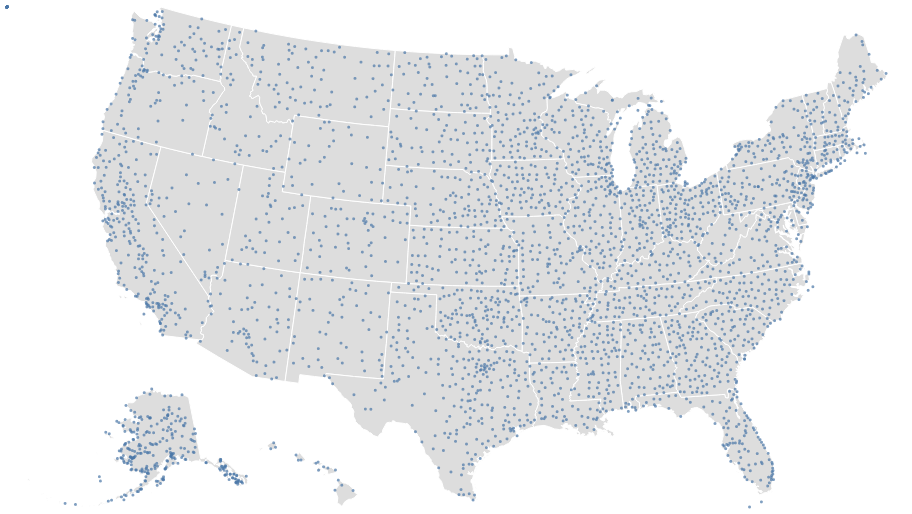

In [19]:
alt.layer(
    alt.Chart(alt.topo_feature(usa, 'states')).mark_geoshape(
        fill='#ddd', stroke='#fff', strokeWidth=1
    ),
    alt.Chart(airports).mark_circle(size=9).encode(
        latitude='latitude:Q',
        longitude='longitude:Q',
        tooltip='iata:N'
    )
).project(
    type='albersUsa'
).properties(
    width=900,
    height=500
).configure_view(
    stroke=None
)

_That's a lot of airports! Obviously, not all of them are major hubs._

Similar to our zip codes dataset, our airport data includes points that lie outside the continental United States. So we again see points in the upper-left corner. We might want to filter these points, but to do so we first need to know more about them.

_Update the map projection above to `albers` &ndash; side-stepping the idiosyncratic behavior of `albersUsa` &ndash; so that the actual locations of these additional points is revealed!_

Now, instead of showing all airports in an undifferentiated fashion, let's identify major hubs by considering the total number of routes that originate at each airport. We'll use the `routes` dataset as our primary data source: it contains a list of flight routes that we can aggregate to count the number of routes for each `origin` airport.

However, the `routes` dataset does not include the _locations_ of the airports! To augment the `routes` data with locations, we need a new data transformation: `lookup`. The `lookup` transform takes a field value in a primary dataset and uses it as a _key_ to look up related information in another table. In this case, we want to match the `origin` airport code in our `routes` dataset against the `iata` field of the `airports` dataset, then extract the corresponding `latitude` and `longitude` fields.

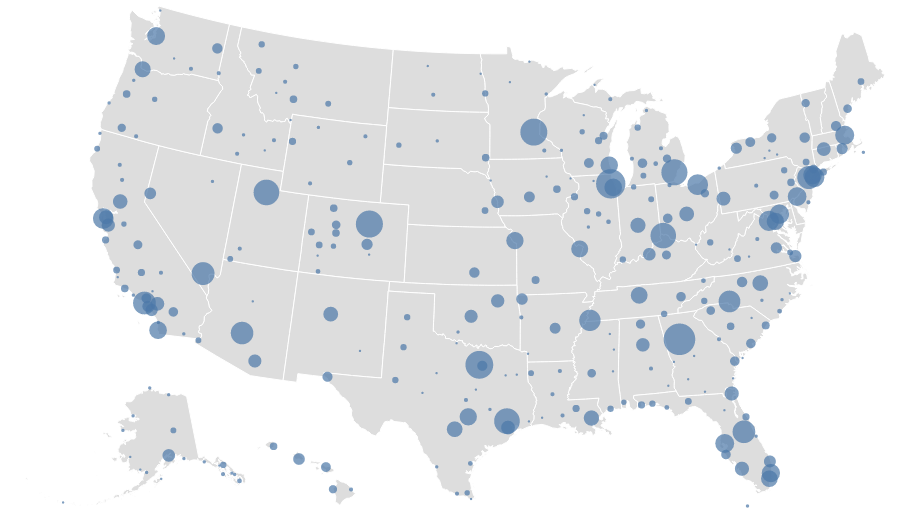

In [20]:
alt.layer(
    alt.Chart(alt.topo_feature(usa, 'states')).mark_geoshape(
        fill='#ddd', stroke='#fff', strokeWidth=1
    ),
    alt.Chart(flights).mark_circle().transform_aggregate(
        groupby=['origin'],
        routes='count()'
    ).transform_lookup(
        lookup='origin',
        from_=alt.LookupData(data=airports, key='iata',
                             fields=['state', 'latitude', 'longitude'])
    ).transform_filter(
        'datum.state !== "PR" && datum.state !== "VI"'
    ).encode(
        latitude='latitude:Q',
        longitude='longitude:Q',
        tooltip=['origin:N', 'routes:Q'],
        size=alt.Size('routes:Q', scale=alt.Scale(range=[0, 1000]), legend=None),
        order=alt.Order('routes:Q', sort='descending')
    )
).project(
    type='albersUsa'
).properties(
    width=900,
    height=500
).configure_view(
    stroke=None
)

_Which U.S. airports have the highest number of outgoing routes?_

Now that we can see the airports, which may wish to interact with them to better understand the structure of the air traffic network. We can add a `rule` mark layer to represent paths from `origin` airports to `destination` airports, which requires two `lookup` transforms to retreive coordinates for each end point. In addition, we can use a `single` selection to filter these routes, such that only the routes originating at the currently selected airport are shown.

_Starting from the static map above, can you build an interactive version? Feel free to skip the code below to engage with the interactive map first, and think through how you might build it on your own!_

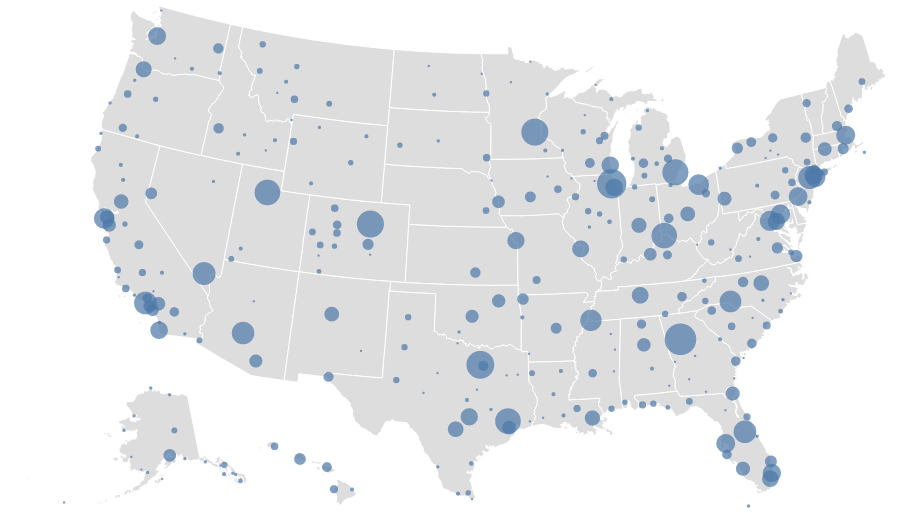

In [21]:
# interactive selection for origin airport
# select nearest airport to mouse cursor
origin = alt.selection_single(
    on='mouseover', nearest=True,
    fields=['origin'], empty='none'
)

# shared data reference for lookup transforms
foreign = alt.LookupData(data=airports, key='iata',
                         fields=['latitude', 'longitude'])
    
alt.layer(
    # base map of the United States
    alt.Chart(alt.topo_feature(usa, 'states')).mark_geoshape(
        fill='#ddd', stroke='#fff', strokeWidth=1
    ),
    # route lines from selected origin airport to destination airports
    alt.Chart(flights).mark_rule(
        color='#000', opacity=0.35
    ).transform_filter(
        origin # filter to selected origin only
    ).transform_lookup(
        lookup='origin', from_=foreign # origin lat/lon
    ).transform_lookup(
        lookup='destination', from_=foreign, as_=['lat2', 'lon2'] # dest lat/lon
    ).encode(
        latitude='latitude:Q',
        longitude='longitude:Q',
        latitude2='lat2',
        longitude2='lon2',
    ),
    # size airports by number of outgoing routes
    # 1. aggregate flights-airport data set
    # 2. lookup location data from airports data set
    # 3. remove Puerto Rico (PR) and Virgin Islands (VI)
    alt.Chart(flights).mark_circle().transform_aggregate(
        groupby=['origin'],
        routes='count()'
    ).transform_lookup(
        lookup='origin',
        from_=alt.LookupData(data=airports, key='iata',
                             fields=['state', 'latitude', 'longitude'])
    ).transform_filter(
        'datum.state !== "PR" && datum.state !== "VI"'
    ).add_selection(
        origin
    ).encode(
        latitude='latitude:Q',
        longitude='longitude:Q',
        tooltip=['origin:N', 'routes:Q'],
        size=alt.Size('routes:Q', scale=alt.Scale(range=[0, 1000]), legend=None),
        order=alt.Order('routes:Q', sort='descending') # place smaller circles on top
    )
).project(
    type='albersUsa'
).properties(
    width=900,
    height=500
).configure_view(
    stroke=None
)

_Mouseover the map to probe the flight network!_

## Choropleth Maps

A [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) uses shaded or textured regions to visualize data values. Sized symbol maps are often more accurate to read, as people tend to be better at estimating proportional differences between the area of circles than between color shades. Nevertheless, choropleth maps are popular in practice and particularly useful when too many symbols become perceptually overwhelming.

For example, while the United States only has 50 states, it has thousands of counties within those states. Let's build a choropleth map of the unemployment rate per county, back in the recession year of 2008. In some cases, input GeoJSON or TopoJSON files might include statistical data that we can directly visualize. In this case, however, we have two files: our TopoJSON file that includes county boundary features (`usa`), and a separate text file that contains unemployment statistics:

In [22]:
unemp = data.unemployment.url
unemp

'https://vega.github.io/vega-datasets/data/unemployment.tsv'

To integrate our data sources, we will again need to use the `lookup` transform, augmenting our TopoJSON-based `geoshape` data with unemployment rates. We can then create a map that includes a `color` encoding for the looked-up `rate` field.

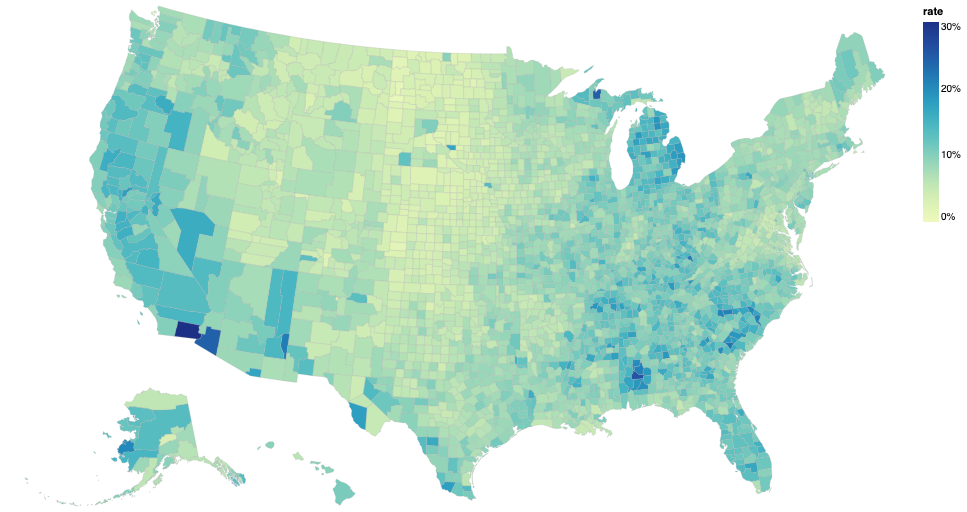

In [23]:
alt.Chart(alt.topo_feature(usa, 'counties')).mark_geoshape(
    stroke='#aaa', strokeWidth=0.25
).transform_lookup(
    lookup='id', from_=alt.LookupData(data=unemp, key='id', fields=['rate'])
).encode(
    alt.Color('rate:Q',
              scale=alt.Scale(domain=[0, 0.3], clamp=True), 
              legend=alt.Legend(format='%')),
    alt.Tooltip('rate:Q', format='.0%')
).project(
    type='albersUsa'
).properties(
    width=900,
    height=500
).configure_view(
    stroke=None
)

*Examine the unemployment rates by county. Higher values in Michigan may relate to the automotive industry. Counties in the [Great Plains](https://en.wikipedia.org/wiki/Great_Plains) and Mountain states exhibit both low **and** high rates. Is this variation meaningful, or is it possibly an [artifact of lower sample sizes](https://medium.com/@uwdata/surprise-maps-showing-the-unexpected-e92b67398865)? To explore further, try changing the upper scale domain (e.g., to `0.2`) to adjust the color mapping.*

A central concern for choropleth maps is the choice of colors. Above, we use Altair's default `'yellowgreenblue'` scheme for heatmaps. Below we compare other schemes, including a _single-hue sequential_ scheme (`teals`) that varies in luminance only, a _multi-hue sequential_ scheme (`viridis`) that ramps in both luminance and hue, and a _diverging_ scheme (`blueorange`) that uses a white mid-point:

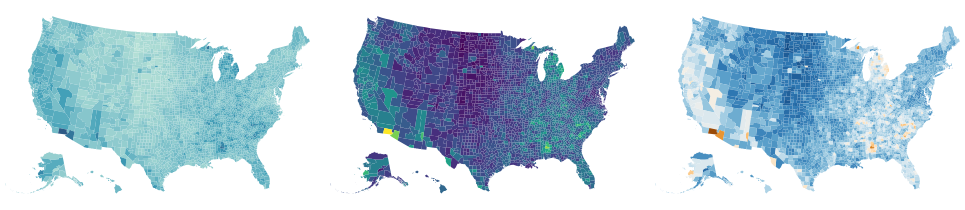

In [24]:
# utility function to generate a map specification for a provided color scheme
def map_(scheme):
    return alt.Chart().mark_geoshape().project(type='albersUsa').encode(
        alt.Color('rate:Q', scale=alt.Scale(scheme=scheme), legend=None)
    ).properties(width=305, height=200)

alt.hconcat(
    map_('tealblues'), map_('viridis'), map_('blueorange'),
    data=alt.topo_feature(usa, 'counties')
).transform_lookup(
    lookup='id', from_=alt.LookupData(data=unemp, key='id', fields=['rate'])
).configure_view(
    stroke=None
).resolve_scale(
    color='independent'
)

_Which color schemes do you find to be more effective? Why might that be? Modify the maps above to use other available schemes, as described in the [Vega Color Schemes documentation](https://vega.github.io/vega/docs/schemes/)._

## Cartographic Projections

Now that we have some experience creating maps, let's take a closer look at cartographic projections. As explained by [Wikipedia](https://en.wikipedia.org/wiki/Map_projection),

> _All map projections necessarily distort the surface in some fashion. Depending on the purpose of the map, some distortions are acceptable and others are not; therefore, different map projections exist in order to preserve some properties of the sphere-like body at the expense of other properties._

Some of the properties we might wish to consider include:

- _Area_: Does the projection distort region sizes?
- _Bearing_: Does a straight line correspond to a constant direction of travel?
- _Distance_: Do lines of equal length correspond to equal distances on the globe?
- _Shape_: Does the projection preserve spatial relations (angles) between points?

Selecting an appropriate projection thus depends on the use case for the map. For example, if we are assessing land use and the extent of land matters, we might choose an area-preserving projection. If we want to visualize shockwaves emanating from an earthquake, we might focus the map on the quake's epicenter and preserve distances outward from that point. Or, if we wish to aid navigation, the preservation of bearing and shape may be more important.

We can also characterize projections in terms of the _projection surface_. Cylindrical projections, for example, project surface points of the sphere onto a surrounding cylinder; the "unrolled" cylinder then provides our map. As we further describe below, we might alternatively project onto the surface of a cone (conic projections) or directly onto a flat plane (azimuthal projections).

*Let's first build up our intuition by interacting with a variety of projections! **[Open the online Vega-Lite Cartographic Projections notebook](https://observablehq.com/@vega/vega-lite-cartographic-projections).** Use the controls on that page to select a projection and explore projection parameters, such as the `scale` (zooming) and x/y translation (panning). The rotation ([yaw, pitch, roll](https://en.wikipedia.org/wiki/Aircraft_principal_axes)) controls determine the orientation of the globe relative to the surface being projected upon.*

### A Tour of Specific Projection Types

[**Cylindrical projections**]() map the sphere onto a surrounding cylinder, then unroll the cylinder. If the major axis of the cylinder is oriented north-south, meridians are mapped to straight lines. [Pseudo-cylindrical](https://en.wikipedia.org/wiki/Map_projection#Pseudocylindrical) projections represent a central meridian as a straight line, with other meridians "bending" away from the center.

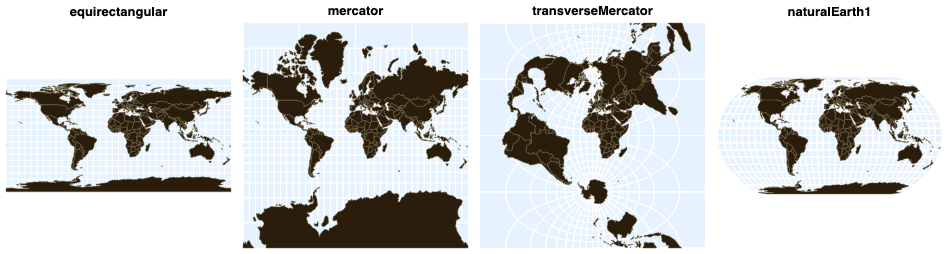

In [25]:
minimap = map.properties(width=225, height=225)
alt.hconcat(
    minimap.project(type='equirectangular').properties(title='equirectangular'),
    minimap.project(type='mercator').properties(title='mercator'),
    minimap.project(type='transverseMercator').properties(title='transverseMercator'),
    minimap.project(type='naturalEarth1').properties(title='naturalEarth1')
).properties(spacing=10).configure_view(stroke=None)

- [Equirectangular](https://en.wikipedia.org/wiki/Equirectangular_projection) (`equirectangular`): Scale `lat`, `lon` coordinate values directly.
- [Mercator](https://en.wikipedia.org/wiki/Mercator_projection) (`mercator`): Project onto a cylinder, using `lon` directly, but subjecting `lat` to a non-linear transformation. Straight lines preserve constant compass bearings ([rhumb lines](https://en.wikipedia.org/wiki/Rhumb_line)), making this projection well-suited to navigation. However, areas in the far north or south can be greatly distorted.
- [Transverse Mercator](https://en.wikipedia.org/wiki/Transverse_Mercator_projection) (`transverseMercator`): A mercator projection, but with the bounding cylinder rotated to a transverse axis. Whereas the standard Mercator projection has highest accuracy along the equator, the Transverse Mercator projection is most accurate along the central meridian.
- [Natural Earth](https://en.wikipedia.org/wiki/Natural_Earth_projection) (`naturalEarth1`): A pseudo-cylindrical projection designed for showing the whole Earth in one view.
<br/><br/>

[**Conic projections**](https://en.wikipedia.org/wiki/Map_projection#Conic) map the sphere onto a cone, and then unroll the cone on to the plane. Conic projections are configured by two _standard parallels_, which determine where the cone intersects the globe.

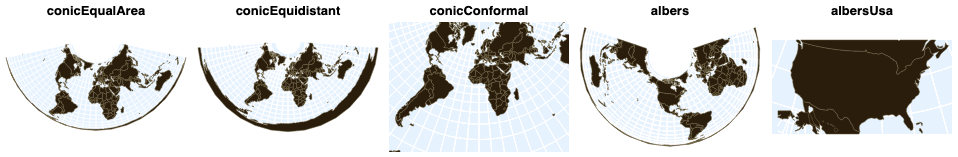

In [26]:
minimap = map.properties(width=180, height=130)
alt.hconcat(
    minimap.project(type='conicEqualArea').properties(title='conicEqualArea'),
    minimap.project(type='conicEquidistant').properties(title='conicEquidistant'),
    minimap.project(type='conicConformal', scale=35, translate=[90,65]).properties(title='conicConformal'),
    minimap.project(type='albers').properties(title='albers'),
    minimap.project(type='albersUsa').properties(title='albersUsa')
).properties(spacing=10).configure_view(stroke=None)

- [Conic Equal Area](https://en.wikipedia.org/wiki/Albers_projection) (`conicEqualArea`): Area-preserving conic projection. Shape and distance are not preserved, but roughly accurate within standard parallels.
- [Conic Equidistant](https://en.wikipedia.org/wiki/Equidistant_conic_projection) (`conicEquidistant`): Conic projection that preserves distance along the meridians and standard parallels.
- [Conic Conformal](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) (`conicConformal`): Conic projection that preserves shape (local angles), but not area or distance.
- [Albers](https://en.wikipedia.org/wiki/Albers_projection) (`albers`): A variant of the conic equal area projection with standard parallels optimized for creating maps of the United States.
- [Albers USA](https://en.wikipedia.org/wiki/Albers_projection) (`albersUsa`): A hybrid projection for the 50 states of the United States of America. This projection stitches together three Albers projections with different parameters for the continental U.S., Alaska, and Hawaii.
<br/><br/>

[**Azimuthal projections**](https://en.wikipedia.org/wiki/Map_projection#Azimuthal_%28projections_onto_a_plane%29) map the sphere directly onto a plane.

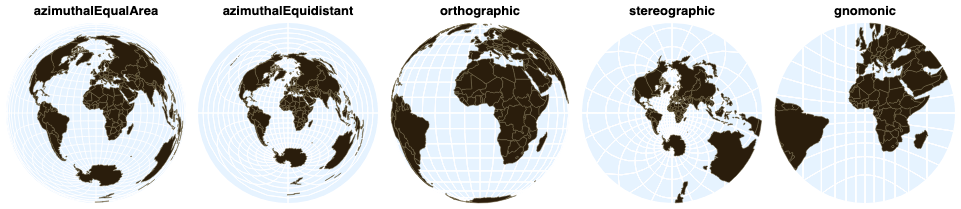

In [27]:
minimap = map.properties(width=180, height=180)
alt.hconcat(
    minimap.project(type='azimuthalEqualArea').properties(title='azimuthalEqualArea'),
    minimap.project(type='azimuthalEquidistant').properties(title='azimuthalEquidistant'),
    minimap.project(type='orthographic').properties(title='orthographic'),
    minimap.project(type='stereographic').properties(title='stereographic'),
    minimap.project(type='gnomonic').properties(title='gnomonic')
).properties(spacing=10).configure_view(stroke=None)

- [Azimuthal Equal Area](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) (`azimuthalEqualArea`): Accurately projects area in all parts of the globe, but does not preserve shape (local angles).
- [Azimuthal Equidistant](https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection) (`azimuthalEquidistant`): Preserves proportional distance from the projection center to all other points on the globe.
- [Orthographic](https://en.wikipedia.org/wiki/Orthographic_projection_in_cartography) (`orthographic`): Projects a visible hemisphere onto a distant plane. Approximately matches a view of the Earth from outer space.
- [Stereographic](https://en.wikipedia.org/wiki/Stereographic_projection) (`stereographic`): Preserves shape, but not area or distance.
- [Gnomonic](https://en.wikipedia.org/wiki/Gnomonic_projection) (`gnomonic`): Projects the surface of the sphere directly onto a tangent plane. [Great circles](https://en.wikipedia.org/wiki/Great_circle) around the Earth are projected to straight lines, showing the shortest path between points.
<br/><br/>

## Coda: Wrangling Geographic Data

The examples above all draw from the vega-datasets collection, including geometric (TopoJSON) and tabular (airports, unemployment rates) data. A common challenge to getting starting with geographic visualization is collecting the necessary data for your task. A number of data providers abound, including services such as the [United States Geological Survey](https://www.usgs.gov/products/data-and-tools/data-and-tools-topics) and [U.S. Census Bureau](https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html).

In many cases you may have existing data with a geographic component, but require additional measures or geometry. To help you get started, here is one workflow:

1. Visit [Natural Earth Data](http://www.naturalearthdata.com/downloads/) and browse to select data for regions and resolutions of interest. Download the corresponding zip file(s).
2. Go to [MapShaper](https://mapshaper.org/) and drop your downloaded zip file onto the page. Revise the data as desired, and then "Export" generated TopoJSON or GeoJSON files.
3. Load the exported data from MapShaper for use with Altair!

Of course, many other tools &ndash; both open-source and proprietary &ndash; exist for working with geographic data. For more about geo-data wrangling and map creation, see Mike Bostock's tutorial series on [Command-Line Cartography](https://medium.com/@mbostock/command-line-cartography-part-1-897aa8f8ca2c).

## Summary

At this point, we've only dipped our toes into the waters of map-making. _(You didn't expect a single notebook to impart centuries of learning, did you?)_ For example, we left untouched topics such as [_cartograms_](https://en.wikipedia.org/wiki/Cartogram) and conveying [_topography_](https://en.wikipedia.org/wiki/Topography) &mdash; as in Imhof's illuminating book [_Cartographic Relief Presentation_](https://books.google.com/books?id=cVy1Ms43fFYC). Nevertheless, you should now be well-equipped to create a rich array of geo-visualizations. For more, MacEachren's book [_How Maps Work: Representation, Visualization, and Design_](https://books.google.com/books?id=xhAvN3B0CkUC) provides a valuable overview of map-making from the perspective of data visualization. 